In [1]:
%load_ext watermark

import warnings
warnings.filterwarnings("ignore")

# File manipulation
import os
import pathlib
import shutil
import wget
import zipfile

# Data manipulation
import numpy as np

# Machine Learning
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Input, Flatten, MaxPool2D, ReLU, Reshape, UpSampling2D
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(1234)

# Image manipulation
import imghdr
from PIL import ImageFile

# Options for PIL
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras

# Options for seaborn
sns.set_style('darkgrid')
%matplotlib inline

# Utils
import leyenda_utils as lu
%watermark -p watermark,wget,numpy,sklearn,tensorflow,tensorflow_hub,PIL,matplotlib,seaborn,visualkeras

In [2]:
DATA_PATH = 'data/image_noise'

data_dir = pathlib.Path(os.path.join(DATA_PATH))
invalid_images = []

for file in list(data_dir.glob('*/*.*')):
    if imghdr.what(file) not in ['jpeg', 'png']:
        invalid_images.append(file)
        
print(f'{len(invalid_images)} invalids images')

0 invalids images


In [3]:
import glob
from skimage import io

images = []

for path in glob.glob(DATA_PATH + '/*'):
    images.append(io.imread(path))

In [4]:
import imgaug.augmenters as iaa
import imgaug as ia

IMG_H, IMG_W = 180, 180

preprocess = iaa.Sequential([
    iaa.Resize((IMG_H, IMG_W))
])

images_pre = np.array(preprocess(images=images))

images_pre.shape

(150, 180, 180, 3)

In [5]:
import imgaug.augmenters as iaa
import imgaug as ia

AUGMENTATION_FACTOR = 10

ia.seed(42)

seq = iaa.Sequential([
    iaa.HorizontalFlip(0.5),
    iaa.VerticalFlip(0.5),
    iaa.Affine(scale=(1, 1.5)),
    iaa.GammaContrast((0.5, 1),
                      per_channel=True),
    iaa.SigmoidContrast(gain=(3, 10),
                        cutoff=(0.4, 0.6),
                        per_channel=True)
])

images_aug = images_pre

for i in range(AUGMENTATION_FACTOR):
    images_aug = np.concatenate((images_aug, seq(images=images_pre)), axis=0)
    
print(images_aug.shape)

(1650, 180, 180, 3)


In [6]:
fractions = np.array([0.8, 0.1, 0.1])

train_split, val_split, test_split = np.array_split(images_aug,
                                                    (fractions[:-1].cumsum() * len(images_aug)).astype(int))
                                                    
print(train_split.shape)
print(val_split.shape)
print(test_split.shape) 

(1320, 180, 180, 3)
(165, 180, 180, 3)
(165, 180, 180, 3)


In [7]:
noise = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=(0, 0.2 * 255),
                              per_channel=True),
    iaa.AdditiveLaplaceNoise(scale=(0, 0.2 * 255))
])

train = train_split / 255
val = val_split / 255
test = test_split / 255

train_noise= noise(images=train_split).astype(np.float32) / 255
val_noise= noise(images=val_split).astype(np.float32) / 255
test_noise= noise(images=test_split).astype(np.float32) / 255

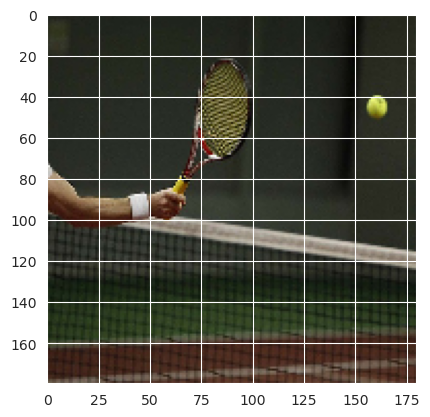

In [8]:
plt.imshow(train[50])

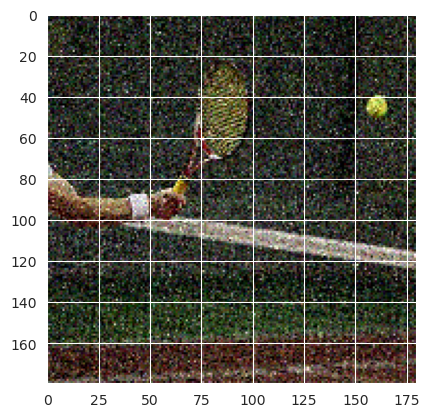

In [9]:
plt.imshow(train_noise[50])

In [10]:
BATCH_SIZE = 16
NUM_EPOCH = 2000
LOSS = MeanSquaredError()
OPTIMIZER = Adam(1e-3)
METRICS = [lu.SSIM]

In [ ]:
dnn_1 = Sequential([
    Flatten(input_shape=(IMG_H, IMG_W, 3)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=IMG_H * IMG_W * 3, activation='relu'),
    Reshape(target_shape=(IMG_H, IMG_W, 3))
], name='dnn_1')

dnn_1.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

visualkeras.layered_view(dnn_1, scale_xy=0.6)

In [ ]:
if lu.is_model_already_trained(dnn_1):
    lu.load_model_training(dnn_1)
else:
    dnn_1.fit(train_noise, train,
              batch_size=BATCH_SIZE,
              epochs= NUM_EPOCH,
              validation_data = (val_noise, val))
            
    lu.save_model_training(dnn_1)

In [ ]:
lu.plot_model_history(dnn_1)

In [ ]:
img_pred = dnn_1.predict(test_noise)

In [ ]:
plt.imshow(test_noise[0])

In [ ]:
plt.imshow(img_pred[0])

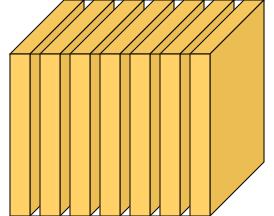

In [13]:
cnn_1 = Sequential([
    Input(shape=(IMG_H, IMG_W, 3)), 
    ###
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    ###
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    ###
    Conv2D(filters=3, kernel_size=(3, 3), padding='same', activation='sigmoid')
], name='cnn_1')

cnn_1.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

visualkeras.layered_view(cnn_1, scale_xy=0.9, scale_z=0.1)

In [15]:
if lu.is_model_already_trained(cnn_1):
    lu.load_model_training(cnn_1)
else:
    cnn_1.fit(train_noise, train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data = (val_noise, val))
            
    lu.save_model_training(cnn_1)

83/83 [==============================] - 121s 1s/step - loss: 0.0040 - SSIM: 0.7195 - val_loss: 0.0036 - val_SSIM: 0.7329


INFO:tensorflow:Assets written to: ram://e343e89e-e7a2-47b9-b7df-0c377c7ce517/assets


INFO:tensorflow:Assets written to: ram://e343e89e-e7a2-47b9-b7df-0c377c7ce517/assets


In [32]:
import json

cnn_1.save('test')
#

INFO:tensorflow:Assets written to: test/assets


INFO:tensorflow:Assets written to: test/assets


In [33]:
test = tf.keras.models.load_model('test', compile=False, custom_objects={"SSIM": lu.SSIM})

In [38]:
import joblib

joblib.load('models/history/cnn_1.pkl')

ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.

In [39]:
h = tf.keras.callbacks.History()
h.

In [ ]:
h.

https://stackoverflow.com/questions/67285790/keras-models-load-model-gives-valueerror

In [ ]:
lu.plot_model_history(cnn_1)

In [ ]:
cnn_1.evaluate(test_noise, test)

In [ ]:
plt.imshow(test_noise[0])

In [ ]:
preds = cnn_1.predict(test_noise)

In [ ]:
plt.imshow(preds[122])

In [ ]:
plt.imshow(test_noise[122])

In [ ]:
test[1]

In [ ]:
dn_cnn = Sequential([
    Input(shape=(IMG_H, IMG_W, 3)),
    ####
    Conv2D(filters=3, kernel_size=(3, 3), padding='same', activation='relu'),
    ####
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    ####
    Conv2D(filters=3, kernel_size=(3, 3), padding='same'),
], name='dn_cnn')

dn_cnn.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

visualkeras.layered_view(dn_cnn, legend=True, scale_xy=0.9, scale_z=0.1)

In [ ]:
if lu.is_model_already_trained(dn_cnn):
    lu.load_model_training(dn_cnn)
else:
    dn_cnn.fit(train_noise, train,
              epochs= NUM_EPOCH,
              validation_data = (val_noise, val))
            
    #lu.save_model_training(dn_cnn)

In [ ]:
lu.plot_model_history(dn_cnn)

https://sh-tsang.medium.com/review-dncnn-residual-learning-of-deep-cnn-image-denoising-super-resolution-jpeg-deblocking-cbf464b03130

https://github.com/wbhu/DnCNN-tensorflow/blob/master/model.py